In [76]:
from __future__ import annotations

import numpy as np
import pandas as pd

from typing import Sequence, Iterable

from nepal.datasets import NYTimes

In [6]:
df_covid = NYTimes().load()


def fill_index(df: pd.DataFrame, names: Sequence[str]) -> pd.DataFrame:
    return df.pipe(_complete_index, names=names).pipe(_fill_na)


def _complete_index(df: pd.DataFrame, names: Sequence[str]) -> pd.DataFrame:
    dates: pd.Index = df.index.get_level_values("date")

    labels = {
        "fips": df.index.get_level_values("fips").unique(),
        "date": pd.date_range(start=dates.min(), end=dates.max(), freq="D"),
    }

    complete: pd.MultiIndex = pd.MultiIndex.from_product(
        [labels[names[0]], labels[names[1]]], names=names
    )

    return df.reindex(complete)


def _fill_na(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(
        county=df.county.bfill(),
        state=df.state.bfill(),
        cases=df.cases.fillna(0),
        deaths=df.deaths.fillna(0),
    )


# Important: date index must be last
index = ["fips", "date"]
df = (
    df_covid.dropna(subset=index)
    .set_index(index)
    .pipe(fill_index, names=index)
    .sort_index(level=index)
)

df

county           state  cases  deaths
fips  date                                                 
01001 2020-01-21     Autauga         Alabama      0       0
      2020-01-22     Autauga         Alabama      0       0
      2020-01-23     Autauga         Alabama      0       0
      2020-01-24     Autauga         Alabama      0       0
      2020-01-25     Autauga         Alabama      0       0
...                      ...             ...    ...     ...
78030 2022-04-07  St. Thomas  Virgin Islands   7206      59
      2022-04-08  St. Thomas  Virgin Islands   7219      59
      2022-04-09  St. Thomas  Virgin Islands   7219      59
      2022-04-10  St. Thomas  Virgin Islands   7219      59
      2022-04-11  St. Thomas  Virgin Islands   7219      59

[2614640 rows x 4 columns]

In [7]:
def cast_types_as_signed(df: pd.DataFrame, cols: Iterable[str]) -> pd.DataFrame:
    return df.astype({col: "int64" for col in cols})


def calculate_new(df: pd.DataFrame, cols: Iterable[str]) -> pd.DataFrame:
    for col in cols:
        df[f"new_{col}"] = df[col].diff().fillna(0).clip(lower=0).astype("int64")
    return df


targets = ["cases", "deaths"]
df = df.pipe(cast_types_as_signed, cols=targets).pipe(calculate_new, cols=targets)

df

county           state  cases  deaths  new_cases  \
fips  date                                                               
01001 2020-01-21     Autauga         Alabama      0       0          0   
      2020-01-22     Autauga         Alabama      0       0          0   
      2020-01-23     Autauga         Alabama      0       0          0   
      2020-01-24     Autauga         Alabama      0       0          0   
      2020-01-25     Autauga         Alabama      0       0          0   
...                      ...             ...    ...     ...        ...   
78030 2022-04-07  St. Thomas  Virgin Islands   7206      59          7   
      2022-04-08  St. Thomas  Virgin Islands   7219      59         13   
      2022-04-09  St. Thomas  Virgin Islands   7219      59          0   
      2022-04-10  St. Thomas  Virgin Islands   7219      59          0   
      2022-04-11  St. Thomas  Virgin Islands   7219      59          0   

                  new_deaths  
fips  date                    
01001 2020-01-21           0  
      2020-01-22           0  
      2020-01-23           0  
      2020-01-24           0  
      2020-01-25           0  
...                      ...  
78030 2022-04-07           0  
      2022-04-08           0  
      2022-04-09           0  
      2022-04-10           0  
      2022-04-11           0  

[2614640 rows x 6 columns]

In [4]:
# Test how we can correctly index a multiindex
df.loc[pd.IndexSlice[:, "2020-01-21":"2020-02-01"], :]

county           state  cases  deaths  new_cases  \
fips  date                                                               
01001 2020-01-21     Autauga         Alabama      0       0          0   
      2020-01-22     Autauga         Alabama      0       0          0   
      2020-01-23     Autauga         Alabama      0       0          0   
      2020-01-24     Autauga         Alabama      0       0          0   
      2020-01-25     Autauga         Alabama      0       0          0   
...                      ...             ...    ...     ...        ...   
78030 2020-01-28  St. Thomas  Virgin Islands      0       0          0   
      2020-01-29  St. Thomas  Virgin Islands      0       0          0   
      2020-01-30  St. Thomas  Virgin Islands      0       0          0   
      2020-01-31  St. Thomas  Virgin Islands      0       0          0   
      2020-02-01  St. Thomas  Virgin Islands      0       0          0   

                  new_deaths  
fips  date                    
01001 2020-01-21           0  
      2020-01-22           0  
      2020-01-23           0  
      2020-01-24           0  
      2020-01-25           0  
...                      ...  
78030 2020-01-28           0  
      2020-01-29           0  
      2020-01-30           0  
      2020-01-31           0  
      2020-02-01           0  

[38640 rows x 6 columns]

In [53]:
from typing import Tuple, Iterator, Dict
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import ExpandingWindowSplitter

fh = ForecastingHorizon(list(range(1, 2)))
cv = ExpandingWindowSplitter(fh=fh, initial_window=5, step_length=5)


def generate_window_splits(
    splitter, y: pd.DataFrame
) -> Iterator[Tuple[pd.DataFrame, pd.DataFrame]]:
    dates: pd.DataFrame = y.index.get_level_values(-1).unique().to_frame()

    for train, test in splitter.split(dates):
        idx_train: pd.Series = dates.iloc[train, 0]
        idx_test: pd.Series = dates.iloc[test, 0]

        yield (y.loc[pd.IndexSlice[:, idx_train], :], y.loc[pd.IndexSlice[:, idx_test], :])


def add_lagged_features(y: pd.DataFrame, *, lag: int = 2, dropna: bool = True) -> pd.DataFrame:
    """
    Builds a new DataFrame to facilitate regressing over all possible lagged features.
    """
    if not isinstance(y, pd.DataFrame):
        raise ValueError("Only works for DataFrame")
    else:
        groupby_levels = range(0, y.index.nlevels - 1)
        data: Dict[str, pd.Series] = {}

        for col_name in y:
            # keep unlagged Series
            data[col_name] = y[col_name]

            # create lagged Series
            for l in range(1, lag + 1):
                data[f"{col_name}_{l}"] = y.groupby(level=groupby_levels)[col_name].shift(l)

        res = pd.DataFrame(data, index=y.index)

    if dropna:
        return res.dropna()
    else:
        return res

In [84]:
import lightgbm as lgb
from typing import Optional, Iterable


class LGBMForecaster:
    def __init__(self, estimator: lgb.LGBMModel, lag: int = 0):
        self._model: lgb.LGBMModel = estimator
        self._lag: int = lag

    @property
    def lag(self) -> int:
        return self._lag

    def fit(
        self, y: pd.DataFrame, X: Optional[Iterable[pd.DataFrame]] = None, **kwargs
    ) -> LGBMForecaster:
        if not X:
            X = []

        targets: Iterable[str] = y.columns
        y_lagged: pd.DataFrame = add_lagged_features(y, lag=self._lag, dropna=True)

        X_t = y_lagged.drop(columns=targets)
        for exogenous in X:
            X_t = X_t.merge(exogenous, how="left", on=exogenous.index)

        y_t = y_lagged[targets]

        self._model = self._model.fit(
            X=X_t, y=y_t, **kwargs
        )

        return self

    def predict(self, fh: ForecastingHorizon, X: Optional[Iterable[pd.DataFrame]] = None, **kwargs) -> pd.DataFrame:
        if not X:
            X = []
        
        # TODO: Need access to training data for this, to generate the correct lagged features.
        self._model.predict()


In [71]:
from typing import List
import warnings


from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as mape
from tqdm.auto import tqdm

from sktime.forecasting.model_selection import SlidingWindowSplitter

# Create regressor with default parameters
forecaster = LGBMForecaster(lgb.LGBMRegressor(), lag=12)

fh = ForecastingHorizon(list(range(1, 15)))
cv = SlidingWindowSplitter(fh=fh, window_length=60, step_length=60)

scores: List[float] = []
for df_train, df_test in tqdm(generate_window_splits(cv, y=df[["new_cases"]]), total=None):
    df_train = add_lagged_features(df_train, lag=lag)
    df_test = add_lagged_features(df_test, lag=lag)

    model = forecaster.fit(y=df_train["new_cases"])

    df_pred = pd.DataFrame(
        model.predict(X=df_test.drop(columns=["new_cases"])), index=df_test.index
    )
    with warnings.catch_warnings():
        warnings.simplefilter(action="ignore", category=FutureWarning)
        score = mape(y_true=df_test["new_cases"], y_pred=df_pred, symmetric=True)
        scores.append(score)

print(np.mean(scores))

0it [00:00, ?it/s]

1.131503173484491


<AxesSubplot:>

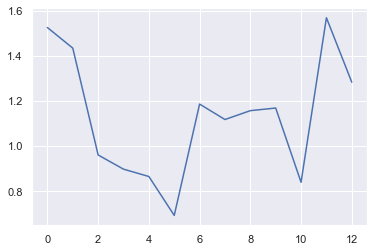

In [72]:
import seaborn as sns

sns.set(style="darkgrid")
sns.lineplot(data=scores)

In [210]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as meap


def sample_fips(df: pd.DataFrame, amount: int) -> pd.DataFrame:
    subindex = df.index.get_level_values("fips")
    sample_ids = np.random.choice(subindex, amount, replace=False)
    return df.loc[sample_ids].sort_index(level=["fips", "date"])


def date_index(df: pd.DataFrame) -> pd.Index:
    idx: pd.Index = df.index.unique("date")
    return pd.DatetimeIndex(idx, freq="D")


y = sample_fips(df, 5)
n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

errors = []
for y_train, y_test in get_windows(y[["new_cases"]]):
    y_pred = forecaster.fit_predict(y=y_train, fh=fh)
    errors.append(meap(y_test, y_pred))

print(np.mean(errors))

Number of Folds = 67


/Users/personal/Documents/Master of Statistics/2/Modern Data Analytics/Project/G0Z39a/.venv/lib/python3.9/site-packages/sktime/utils/datetime.py:105: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if not hasattr(x, "freq") or x.freq is None:
/Users/personal/Documents/Master of Statistics/2/Modern Data Analytics/Project/G0Z39a/.venv/lib/python3.9/site-packages/sktime/utils/datetime.py:107: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  by *= x.freq


TypeError: Level type mismatch: 2020-02-20 00:00:00